In [1]:
from torch_geometric.datasets import PPI
import torch_geometric.transforms as T
from torch_geometric.utils import add_self_loops
from torch_geometric.loader import DataLoader

train_dataset = PPI(root='/tmp/PPI', split="train")
val_dataset = PPI(root='/tmp/PPI', split="val")
test_dataset = PPI(root='/tmp/PPI', split="test")
# train_dataset.transform = T.NormalizeFeatures()
# val_dataset.transform = T.NormalizeFeatures()
# test_dataset.transform = T.NormalizeFeatures()

train_loader = iter(DataLoader(train_dataset, batch_size=len(train_dataset)))
val_loader = iter(DataLoader(val_dataset, batch_size=len(val_dataset)))
test_loader = iter(DataLoader(test_dataset, batch_size=len(test_dataset)))

In [2]:
train_dataset

PPI(20)

In [3]:
train_set = next(train_loader)
test_set = next(test_loader)
val_set = next(val_loader)

In [4]:
train_set.y.shape[-1]

121

In [5]:
import torch
from torch import nn
from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
class GNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout = .2, normalize = False, add_self_loops = True):
        super(GNN, self).__init__()
        
        self.conv1 = GCNConv(in_dim, hidden_dim, normalize = normalize, add_self_loops=add_self_loops)
        self.lin1 = Linear(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim, normalize = normalize, add_self_loops=add_self_loops)
        self.lin2 = Linear(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, out_dim, normalize = normalize, add_self_loops=add_self_loops)
        self.lin3 = Linear(hidden_dim, out_dim)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x, edge_index):
        x = self.dropout(x)
        x = self.conv1(x, edge_index) + self.lin1(x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index) + self.lin2(x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index) + self.lin3(x)
        return x

In [6]:
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
train_set = train_set.to(device)
val_set = val_set.to(device)
test_set = test_set.to(device)

In [7]:
TRAIN = "train"
VAL = "val"
TEST = "test"

In [8]:
set_names = [TRAIN, TEST, VAL]

In [9]:
sets = dict()
sets[TRAIN] = train_dataset
sets[TEST] = test_dataset
sets[VAL] = val_dataset

In [41]:
from sklearn.model_selection import ParameterGrid
import  matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from torcheval.metrics.functional import multiclass_f1_score
import copy

space = {
    "WEIGHT_DECAYS": [0],#[0, 1e-3]
"DROPOUT": [0.0, 0.2, 0.4],
"HIDDEN_DIMS": [128, 256, 512],#[16, 32, 64, 128],
"LEARNING_RATES": [1e-4, 5e-3, 1e-3, 5e-4],
    "SELF_LOOPS": [True, False],#[True, False]
    "NORMALIZE": [True, False],#[True, False],
}

param_grid = ParameterGrid(space)
best_params_overall = None
best_val_overall = float("inf")

for params in tqdm(param_grid.__iter__()):
    EPOCHS = 1000
    HIDDEN_DIM = params["HIDDEN_DIMS"]
    DROPOUT = params["DROPOUT"]
    LEARNING_RATE = params["LEARNING_RATES"]
    WEIGHT_DECAY = params["WEIGHT_DECAYS"]
    SELF_LOOPS = params["SELF_LOOPS"]
    NORMALIZE = params["NORMALIZE"]
    PATIENCE = 100
    PATIENCE_COUNT = 0
    
    model = GNN(in_dim=train_set.x.shape[-1], hidden_dim=HIDDEN_DIM, out_dim=train_set.y.shape[-1], dropout = DROPOUT,
               normalize = NORMALIZE, add_self_loops=SELF_LOOPS).to(device)
    optim = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction='mean')
    # models = []
    
    losses = dict()
    for set_name in set_names: losses[set_name] = []
    scores = dict()
    for set_name in set_names: scores[set_name] = []
    best_val_loss = float("inf")
    test_acc = 0
    
    def validate(set_name):
        global best_val_loss,  test_acc, PATIENCE_COUNT
        acc_loss = 0
        batch_size = 0
        ground_truth = []
        preds = []
        with torch.inference_mode():
            model.eval()
            set = sets[set_name]
    
            for loader in set:
                loader = loader.to(device)
                out = model(loader.x, loader.edge_index)
                loss = loss_fn(out, loader.y)
                ground_truth.append(loader.y)
                preds.append((out > 0).float())
                acc_loss += loss.item()
                batch_size+=1
                
        score = f1_score(torch.cat(ground_truth).cpu(), torch.cat(preds).detach().cpu(), average ="micro")
        scores[set_name].append(score)
        
        if set_name == VAL and best_val_loss >= acc_loss:
            best_val_loss = acc_loss
            # test_acc = scores[TEST][-1]
            PATIENCE_COUNT = 0
        else:
            PATIENCE_COUNT += 1
        # models.append(copy.deepcopy(model))
        losses[set_name].append(acc_loss / batch_size)
    
    def train():
        global PATIENCE_COUNT
        for epoch in tqdm(range(EPOCHS)):
            acc_loss = 0
            for loader in train_dataset:
                loader = loader.to(device)
                optim.zero_grad()
                model.train()
                out = model(loader.x, loader.edge_index)
                loss = loss_fn(out, loader.y)
                acc_loss += loss.item()
                loss.backward()
                optim.step()
                
            for set_name in set_names:
                if set_name != VAL:
                    continue
                validate(set_name)
            if PATIENCE_COUNT == PATIENCE:#epoch > EPOCHS // 2 and losses[VAL][-1] > torch.mean(torch.tensor(losses[VAL][-(PATIENCE+1):])).item():
                break
    train()
    if best_val_loss <= best_val_overall:
        best_val_overall = best_val_loss
        best_params_overall = params

0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [42]:
best_val_overall

0.18172244727611542

In [43]:
best_params_overall

{'DROPOUT': 0.2,
 'HIDDEN_DIMS': 512,
 'LEARNING_RATES': 0.005,
 'NORMALIZE': True,
 'SELF_LOOPS': True,
 'WEIGHT_DECAYS': 0}

In [10]:
import  matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from torcheval.metrics.functional import multiclass_f1_score
import copy
##TODO Write hyperparam tune loop 


EPOCHS = 1000 #200
HIDDEN_DIM = 512 #64
SELF_LOOPS = True
NORMALIZE = True
DROPOUT = 0.2
LEARNING_RATE = 0.005
WEIGHT_DECAY = 0
PATIENCE = 100
PATIENCE_COUNT = 0


model = GNN(in_dim=train_set.x.shape[-1], hidden_dim=HIDDEN_DIM, out_dim=train_set.y.shape[-1], dropout = DROPOUT,
               add_self_loops=SELF_LOOPS, normalize = NORMALIZE).to(device)
optim = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = torch.nn.BCEWithLogitsLoss(reduction='mean')
best_model = None

losses = dict()
for set_name in set_names: losses[set_name] = []
scores = dict()
for set_name in set_names: scores[set_name] = []
best_val_loss = float("inf")
test_acc = 0

def validate(set_name):
    global best_val_loss,  test_acc, PATIENCE_COUNT
    acc_loss = 0
    batch_size = 0
    ground_truth = []
    preds = []
    with torch.inference_mode():
        model.eval()
        set = sets[set_name]

        for loader in set:
            loader = loader.to(device)
            out = model(loader.x, loader.edge_index)
            loss = loss_fn(out, loader.y)
            ground_truth.append(loader.y)
            preds.append((out > 0).float())
            acc_loss += loss.item()
            batch_size+=1
            
    score = f1_score(torch.cat(ground_truth).cpu(), torch.cat(preds).detach().cpu(), average ="micro")
    scores[set_name].append(score)
    
    if set_name == VAL and best_val_loss >= acc_loss:
        best_val_loss = acc_loss
        # test_acc = scores[TEST][-1]
        PATIENCE_COUNT = 0
    else:
        if PATIENCE_COUNT == 0:
            best_model = copy.deepcopy(model)
        PATIENCE_COUNT += 1
    
    losses[set_name].append(acc_loss / batch_size)

def train():
    global PATIENCE_COUNT, best_model
    for epoch in tqdm(range(EPOCHS)):
        acc_loss = 0
        for loader in train_dataset:
            loader = loader.to(device)
            optim.zero_grad()
            model.train()
            out = model(loader.x, loader.edge_index)
            loss = loss_fn(out, loader.y)
            acc_loss += loss.item()
            loss.backward()
            optim.step()
            
        for set_name in set_names:
            # if set_name != VAL:
            #     continue
            validate(set_name)
        if PATIENCE_COUNT == PATIENCE:#epoch > EPOCHS // 2 and losses[VAL][-1] > torch.mean(torch.tensor(losses[VAL][-(PATIENCE+1):])).item():
            break
    if best_model is None:
        best_model = copy.deepcopy(model)
train()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
model = copy.deepcopy(model)

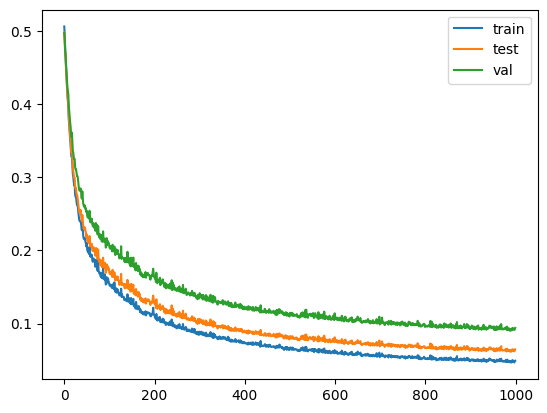

In [12]:
for set_name in set_names: plt.plot(losses[set_name])
plt.legend(set_names)

In [13]:
ground_truth = []
preds = []
# model = models[-(PATIENCE+1)]
for loader in sets[TEST]:
    loader = loader.to(device)
    out = model(loader.x, loader.edge_index)
    preds.append(out)
    ground_truth.append(loader.y)    

In [14]:
f1_score(torch.cat(ground_truth).cpu(), (torch.cat(preds).cpu().detach() > 0).float(), average = "micro")

0.9596413455559345